In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point

# for qqplot
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
# for adding some text in plot
from matplotlib.offsetbox import AnchoredText

# for train test split, for cross validation, and for measure
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import mean_squared_error as MSE
# for data standard scaler
from sklearn.preprocessing import StandardScaler

# for Multiple linear regression
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col

# for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

In [2]:
import libpysal
import mgwr
import esda
from mgwr.gwr import GWR, MGWR
from matplotlib import colors
import spreg

# MSOA shapefile data

In [3]:
msoa_ew_shp_url = "https://github.com/ShengAric92/CASA0010_dissertation/raw/main/MSOA_data/shapefile/England/MSOA_EngWal_Dec_2011_Generalised_ClippedEW_0/Middle_Layer_Super_Output_Areas_December_2011_Generalised_Clipped_Boundaries_in_England_and_Wales.shp"
msoa_ew_shp = gpd.read_file(msoa_ew_shp_url)

In [4]:
msoa_england_shp = msoa_ew_shp[msoa_ew_shp['msoa11cd'].str.startswith("E")]

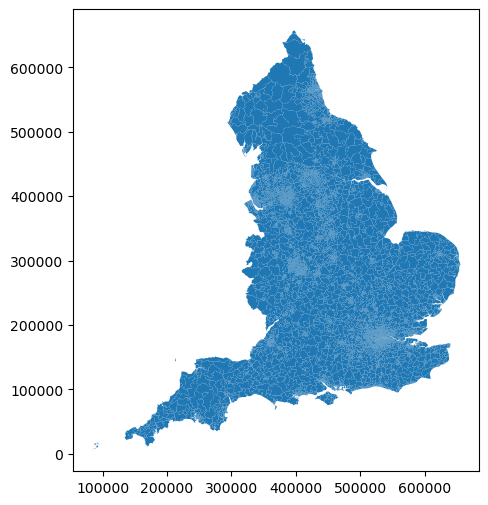

In [5]:
f, axes = plt.subplots(1, 1, figsize=(6, 6))
msoa_england_shp.plot(ax=axes)
plt.show()

# Region and MSOA plot Study Area

In [6]:
uk_region_url = "https://github.com/ShengAric92/CASA0010_dissertation/raw/main/MSOA_data/shapefile/Region/georef-united-kingdom-region/georef-united-kingdom-region-millesime.shp"
uk_region = gpd.read_file(uk_region_url)
uk_region = uk_region.to_crs(epsg=27700)

eng_region = uk_region[uk_region['ctry_code'].str.contains("E")]

eng_region.loc[:, 'rgn_name'] = eng_region['rgn_name'].str.strip("[]").str.replace("'", "")

In [7]:
eng_region

,year,ctry_code,ctry_name,rgn_code,rgn_name,rgn_area_co,rgn_type,geometry
0,2022,['E92000001'],['England'],['E12000002'],North West,GBR,region,"MULTIPOLYGON (((318617.301 467088.835, 319319...."
1,2022,['E92000001'],['England'],['E12000006'],East of England,GBR,region,"MULTIPOLYGON (((583533.751 185582.550, 583629...."
2,2022,['E92000001'],['England'],['E12000007'],London,GBR,region,"POLYGON ((553156.570 175519.807, 553184.397 17..."
3,2022,['E92000001'],['England'],['E12000005'],West Midlands,GBR,region,"POLYGON ((445790.300 252455.405, 445663.103 25..."
4,2022,['E92000001'],['England'],['E12000004'],East Midlands,GBR,region,"MULTIPOLYGON (((552915.124 326370.414, 552598...."
6,2022,['E92000001'],['England'],['E12000003'],Yorkshire and The Humber,GBR,region,"MULTIPOLYGON (((495603.100 422511.497, 496102...."
7,2022,['E92000001'],['England'],['E12000001'],North East,GBR,region,"MULTIPOLYGON (((408764.568 644949.215, 409475...."
8,2022,['E92000001'],['England'],['E12000009'],South West,GBR,region,"MULTIPOLYGON (((87795.451 8849.150, 88606.132 ..."
10,2022,['E92000001'],['England'],['E12000008'],South East,GBR,region,"MULTIPOLYGON (((448615.801 96641.300, 449349.3..."


In [8]:
msoa_england_shp

,objectid,msoa11cd,msoa11nm,msoa11nmw,st_areasha,st_lengths,geometry
0,1,E02000001,City of London 001,City of London 001,2.905399e+06,9024.059703,"MULTIPOLYGON (((532136.950 182198.368, 532160...."
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,2.165634e+06,8152.697593,"POLYGON ((548883.435 190845.558, 548882.997 19..."
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,2.143565e+06,9118.449453,"POLYGON ((549104.294 189324.880, 548956.354 18..."
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,2.490215e+06,8207.610394,"POLYGON ((551551.892 187364.909, 551479.898 18..."
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,1.186180e+06,6964.961665,"POLYGON ((549101.500 187656.302, 549163.242 18..."
...,...,...,...,...,...,...,...
6786,6787,E02006930,Greenwich 037,Greenwich 037,8.678832e+05,7693.140533,"POLYGON ((539554.296 178604.153, 539534.818 17..."
6787,6788,E02006931,Greenwich 038,Greenwich 038,1.986049e+06,8625.942313,"POLYGON ((538836.564 177736.860, 538882.059 17..."
6788,6789,E02006932,Liverpool 060,Liverpool 060,1.470333e+06,12336.973288,"POLYGON ((335717.045 391200.846, 335752.226 39..."
6789,6790,E02006933,Liverpool 061,Liverpool 061,1.626018e+06,9440.159823,"POLYGON ((335061.510 390303.175, 335079.030 39..."


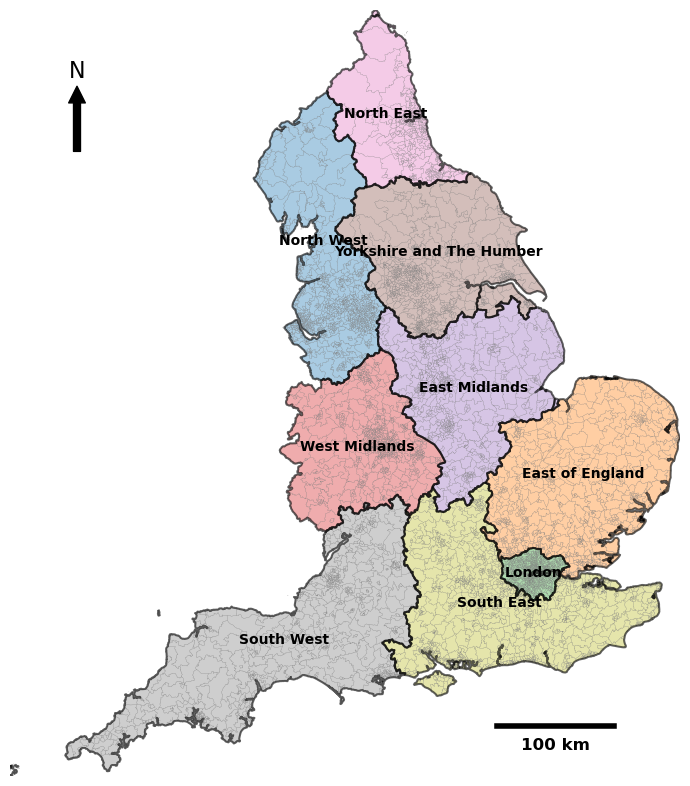

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

msoa_gdf = msoa_england_shp
region_gdf = eng_region

fig, ax = plt.subplots(figsize=(7, 9))

# plot MSOA boundary
msoa_gdf.boundary.plot(color='gray', linewidth=0.1, ax=ax)

# plot Region boundary and add name
region_gdf.boundary.plot(color='black', linewidth=1.5, alpha=0.6, ax=ax)
for idx, row in region_gdf.iterrows():
    ax.annotate(text=row['rgn_name'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                fontsize=10, fontweight='bold', color='black',
                ha='center', va='center')

# the bounds for map
ax.set_xlim(region_gdf.total_bounds[0], region_gdf.total_bounds[2])
ax.set_ylim(region_gdf.total_bounds[1], region_gdf.total_bounds[3])


# add north arrow
def addNarrow(ax, x=0.1, y=0.9, arrow_length=0.085):
    ax.annotate('N', xy=(x, y), xytext=(x, y + 0.02),
                fontsize=16, xycoords='axes fraction',
                ha='center', va='center')
    
    ax.annotate('', xy=(x, y), xytext=(x, y - 0.085),
                arrowprops=dict(facecolor='black', width=5, headwidth=12),
                fontsize=12, xycoords='axes fraction',
                ha='center', va='center')

addNarrow(ax)

# add scalebar
x1, y1 = 500000, 50000
x2, y2 = 600000, 50000

ax.plot([x1, x2], [y1, y2], color='black', lw=4)
ax.text((x1 + x2) / 2, y1 - 10000, '100 km',
        ha='center', va='top', fontsize=12, fontweight='bold')

# adding color for each region for visualization
color_select = plt.cm.get_cmap('tab10')
color_region = [color_select(i) for i in range(len(region_gdf))]
region_gdf.plot(color=color_region, alpha=0.38, edgecolor='none', ax=ax)

# remove axis
ax.axis('off')

plt.tight_layout()
plt.show()

# MSOA All data

In [10]:
Vardata_url = "https://github.com/ShengAric92/CASA0010_dissertation/raw/main/MSOA_data/All_msoa_data/msoa_all_data.csv"
Vardata = pd.read_csv(Vardata_url)

In [11]:
Varshp = pd.merge(msoa_england_shp, Vardata, how='left', left_on='msoa11cd', right_on='MSOA11CD')

# IMD LSOA and MSOA data

In [12]:
lsoa_ew_shp_url = "https://github.com/ShengAric92/CASA0010_dissertation/raw/main/MSOA_data/shapefile/England/Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales/Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.shp"
lsoa_ew_shp = gpd.read_file(lsoa_ew_shp_url)

lsoa_england_shp = lsoa_ew_shp[lsoa_ew_shp['lsoa11cd'].str.startswith("E")]

In [13]:
lsoa_england_shp = lsoa_england_shp.to_crs(epsg=27700)

In [14]:
lsoa_IMD_url = "https://github.com/ShengAric92/CASA0010_dissertation/raw/main/MSOA_data/Variable_x/IMD/File_7_-_All_IoD2019_Scores__Ranks__Deciles_and_Population_Denominators_3.csv"
lsoa_IMD = pd.read_csv(lsoa_IMD_url)

In [15]:
lsoa_IMD = lsoa_IMD[['LSOA code (2011)', 'Index of Multiple Deprivation (IMD) Score',
                     'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)',
                     'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)']]

In [16]:
lsoa_IMD.columns = ['LSOA11CD', 'IMDscore', 'IMDrank', 'IMDdecile']

In [17]:
lsoa_IMD_shp = pd.merge(lsoa_england_shp, lsoa_IMD, how='left', left_on='lsoa11cd', right_on='LSOA11CD')

# Adding selected cities for visualization

In [18]:
# adding the selected city for notation
city_url = "https://github.com/ShengAric92/CASA0010_dissertation/raw/main/MSOA_data/shapefile/City/Major_Towns_and_Cities_Dec_2015_Boundaries_V2_2022_6499499175450461948/TCITY_2015_EW_BGG_V2.shp"
city_shp = gpd.read_file(city_url)
selected_city = ['London', 'Oxford', 'Cambridge', 'Norwich', 'Plymouth', 'Southampton','Brighton and Hove',
                 'Bristol', 'Birmingham', 'Nottingham', 'Sheffield', 'Liverpool', 'Manchester', 'York',
                 'Newcastle upon Tyne', 'Grimsby', 'Leeds']
city_shp = city_shp[city_shp.TCITY15NM.isin(selected_city)]

# Generalization map function

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# write a generalization function for map
def map_plot(m, n, msoagdf, regiongdf, shpdata, variable, cmapcolor, city_open):

    msoa_gdf = msoagdf
    region_gdf = regiongdf
    shp_data = shpdata

    fig, ax = plt.subplots(figsize=(m, n))

    # plot Region boundary
    region_gdf.boundary.plot(color='black', linewidth=1, alpha=1, ax=ax)
    # plot MSOA boundary
    msoa_gdf.boundary.plot(color='gray', linewidth=0.1, alpha=0.1, ax=ax)


    # plot the DM prevalence for MSOA
    shp_data.plot(column=variable, scheme='quantiles', k=5,
                  cmap=cmapcolor, legend=True, ax=ax)
    
    if city_open >= 1:
        # add city notation
        city_shp.plot(ax=ax, alpha=0)
        # plot the city
        for idx, row in city_shp.iterrows():
            # get the location for each city
            x, y = row.geometry.centroid.x, row.geometry.centroid.y
            # plot the city location with star marker
            ax.plot(x, y, marker='*', color='blue', markersize=8, alpha=0.6)

            if city_open > 1:
            # plot the name of each city with clear white path effect for visualization
                text = ax.text(x, y+6000, row['TCITY15NM'], fontsize=8.5, color='white', fontweight='bold', alpha=0.9,
                               ha='center', va='bottom')
                text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black', alpha=0.9),
                                       path_effects.Normal()])


    # add north arrow
    def addNarrow(ax, x=0.1, y=0.9, arrow_length=0.085):
        ax.annotate('N', xy=(x, y), xytext=(x, y + 0.02),
                    fontsize=16, xycoords='axes fraction',
                    ha='center', va='center')

        ax.annotate('', xy=(x, y), xytext=(x, y - 0.085),
                    arrowprops=dict(facecolor='black', width=5, headwidth=12),
                    fontsize=12, xycoords='axes fraction',
                    ha='center', va='center')

    addNarrow(ax)

    # add scalebar
    x1, y1 = 500000, 35000
    x2, y2 = 600000, 35000

    ax.plot([x1, x2], [y1, y2], color='black', lw=4)
    ax.text((x1 + x2) / 2, y1 - 10000, '100 km',
            ha='center', va='top', fontsize=12, fontweight='bold')


    # remove axis
    # ax.axis('off')
    # remove axis params
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    plt.tight_layout()
    plt.show()

# IMD LSOA and MSOA plot

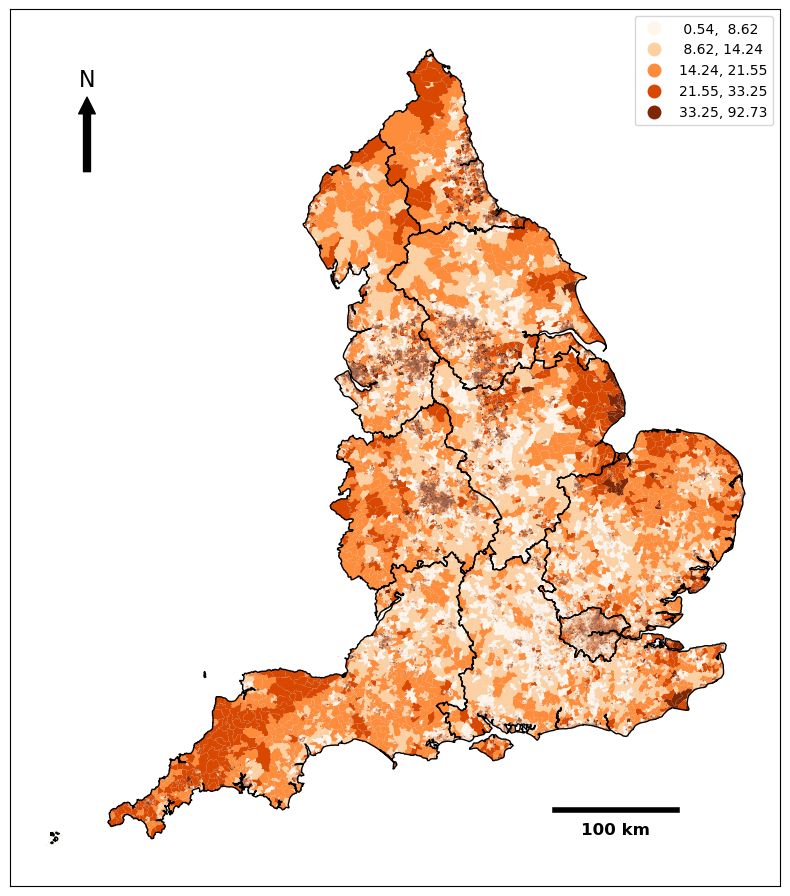

In [20]:
# IMD LSOA plot
map_plot(8, 12, lsoa_england_shp, eng_region, lsoa_IMD_shp, 'IMDscore', 'Oranges', 0)

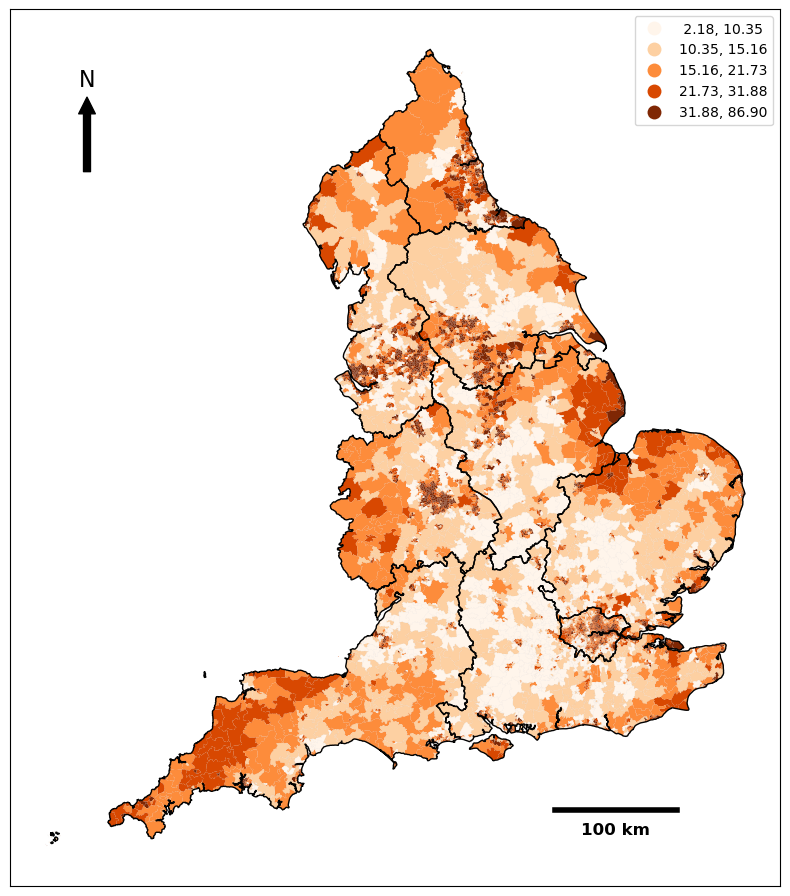

In [21]:
# IMD MSOA plot
map_plot(8, 12, msoa_england_shp, eng_region, Varshp, 'IMDscore', 'Oranges', 0)

# DM Prevalence plot

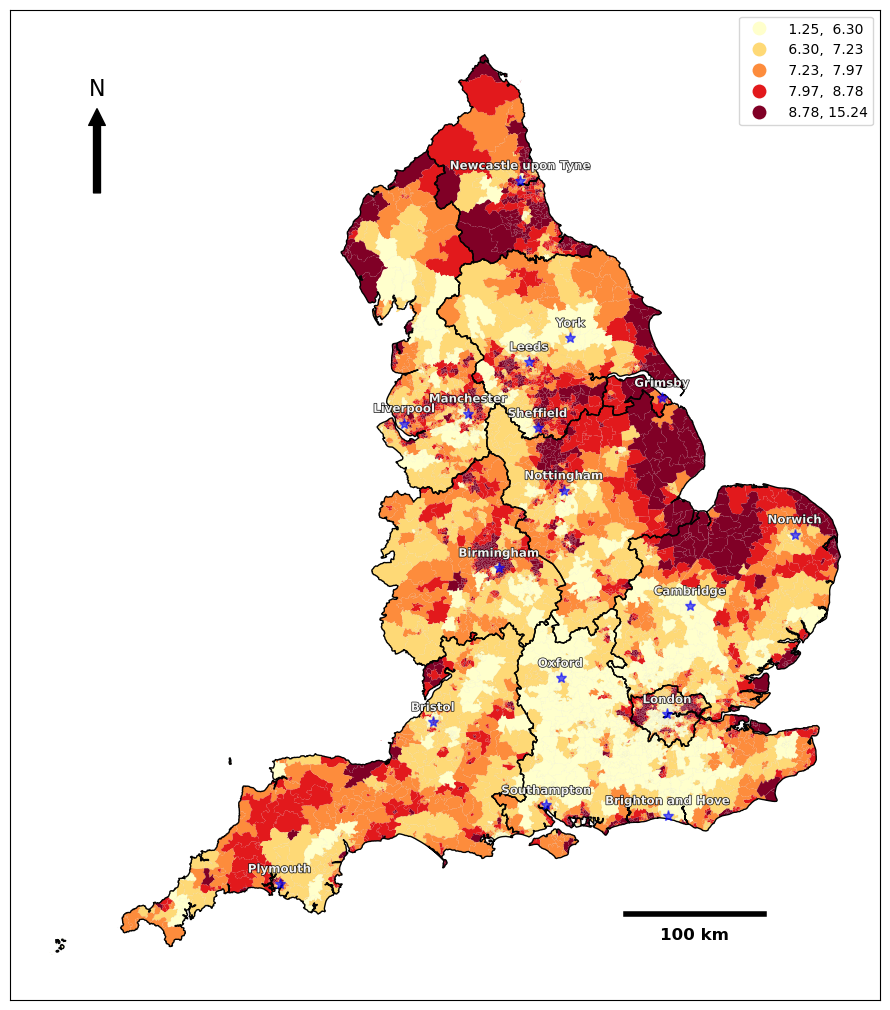

In [22]:
# DM prevalence plot
map_plot(9, 12, msoa_england_shp, eng_region, Varshp, 'DMprev', 'YlOrRd', 2)

## DM Prevalence Violin plot by Region and IMD decile

In [23]:
# using the additional mapping tabel map MSOA to Region
OA_csv = pd.read_csv("/Users/shengaric/Desktop/CASA0010 Dissertation/MSOA_data/shapefile/RegiontoOAtoMSOA/OA11_LSOA11_MSOA11_LAD20_RGN20_EW_LU_a1cf695c9b074c708921b2a7555f808a_354559918831379438.csv")
OA_csv = OA_csv[OA_csv.MSOA11CD.str.startswith("E")]
OA_csv = OA_csv[['MSOA11CD', 'RGN20CD', 'RGN20NM']]
OA_csv = OA_csv.drop_duplicates(subset='MSOA11CD')

Varshpcopy = Varshp.copy()
Varshpregion = pd.merge(Varshpcopy, OA_csv, how='left', left_on='MSOA11CD', right_on='MSOA11CD')

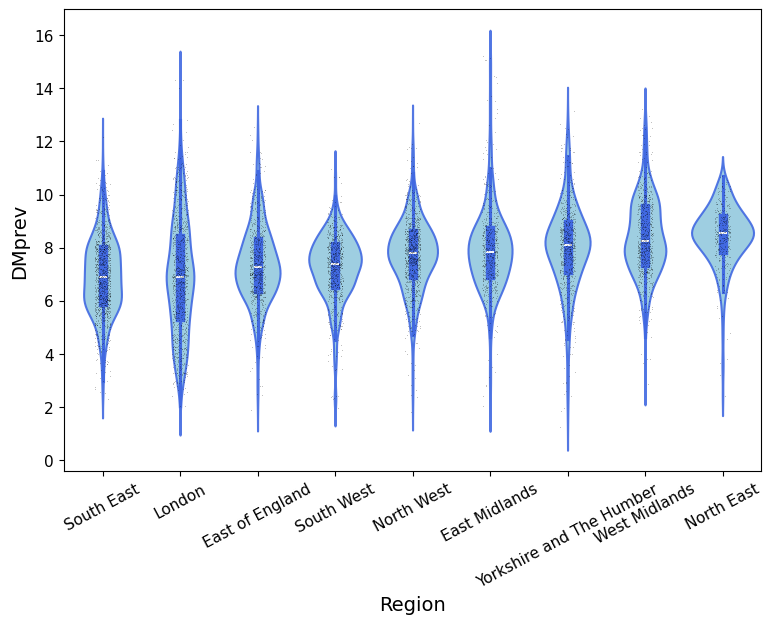

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# calculate median order for Region
orderbyregion = Varshpregion.groupby('RGN20NM')['DMprev'].median().sort_values(ascending=True).index

# plot the violin plot for Region and DM prevalence, order by Region
plt.figure(figsize=(9, 6))
sns.violinplot(x='RGN20NM', y='DMprev', data=Varshpregion, order=orderbyregion,
               alpha=0.9, inner='box', color='skyblue', linewidth=1.5, edgecolor='royalblue')
sns.stripplot(x="RGN20NM", y="DMprev", data=Varshpregion, color='black', size=0.35, jitter=True, alpha=0.7)

plt.xlabel('Region', fontsize=14)
plt.ylabel('DMprev', fontsize=14)
plt.xticks(fontsize=11) 
plt.yticks(fontsize=11)
# rotation the xlabel
plt.xticks(rotation=28)

plt.show()

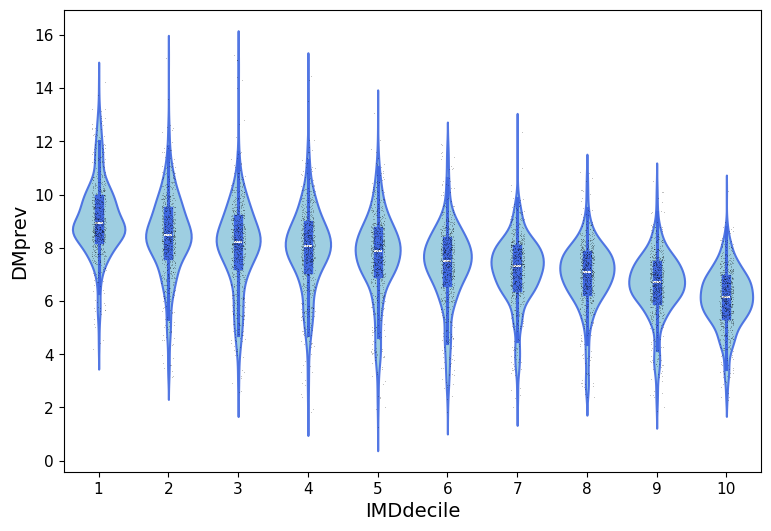

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# plot the violin plot for Imddecile and DM prevalence
plt.figure(figsize=(9, 6))
sns.violinplot(x='IMDdecile', y='DMprev', data=Varshpregion,
               alpha=0.9, inner='box', color='skyblue', linewidth=1.5, edgecolor='royalblue')
sns.stripplot(x="IMDdecile", y="DMprev", data=Varshpregion, color='black', size=0.35, jitter=True, alpha=0.7)

plt.xlabel('IMDdecile', fontsize=14)
plt.ylabel('DMprev', fontsize=14)
plt.xticks(fontsize=11) 
plt.yticks(fontsize=11)
plt.show()

## Map compare OBprev, IMDdecile, Asian and DMprev

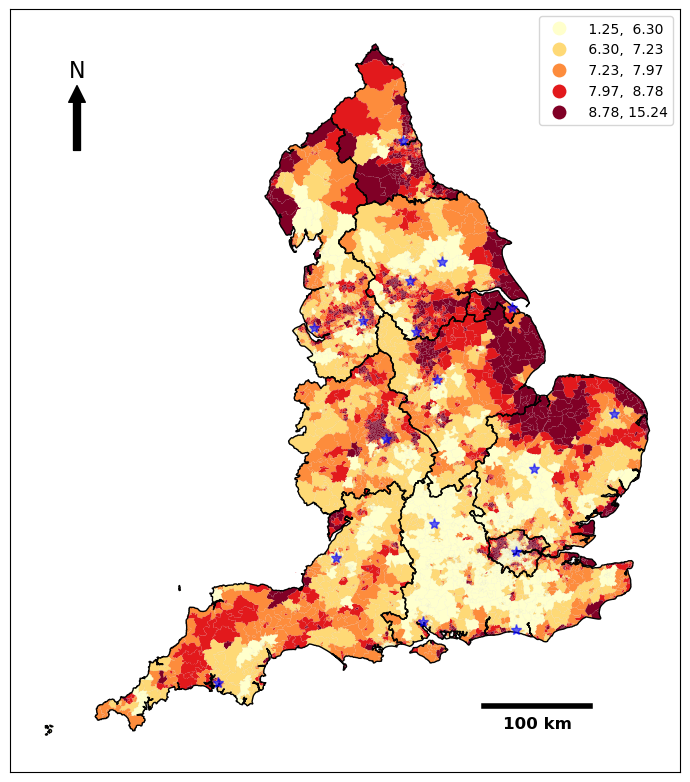

In [26]:
# DM prevalence plot
map_plot(7, 10, msoa_england_shp, eng_region, Varshp, 'DMprev', 'YlOrRd', 1)

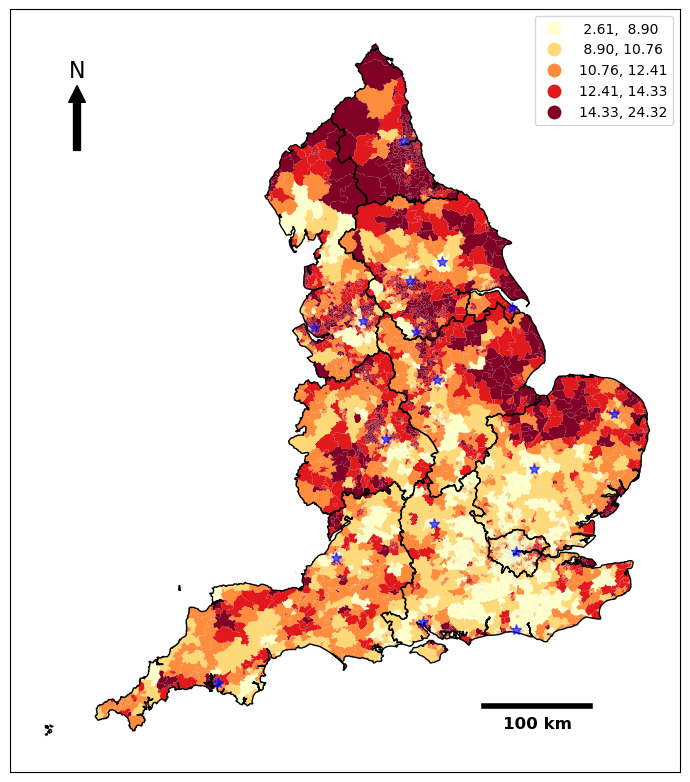

In [27]:
# OB prevalence plot
map_plot(7, 10, msoa_england_shp, eng_region, Varshp, 'OBprev', 'YlOrRd', 1)

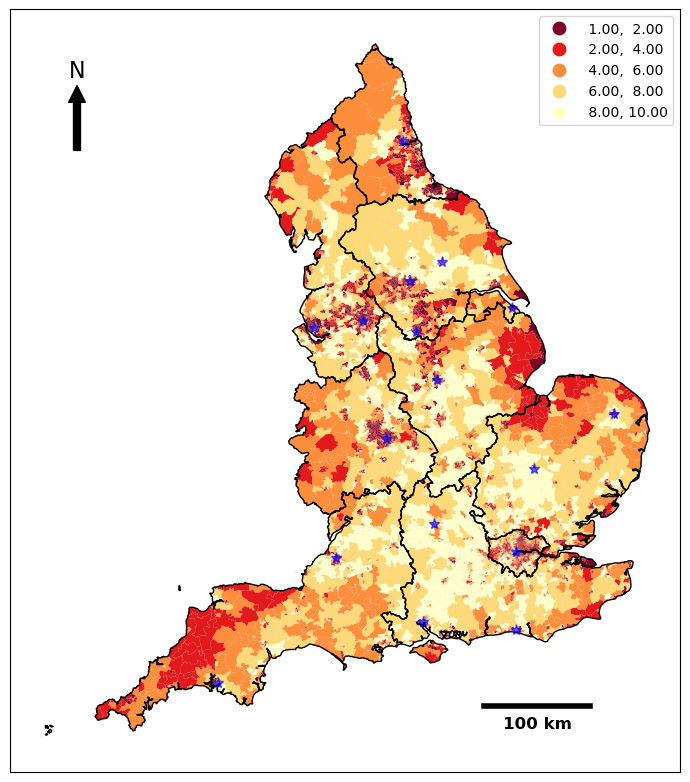

In [28]:
# IMD decile plot
map_plot(7, 10, msoa_england_shp, eng_region, Varshp, 'IMDdecile', 'YlOrRd_r', 1)

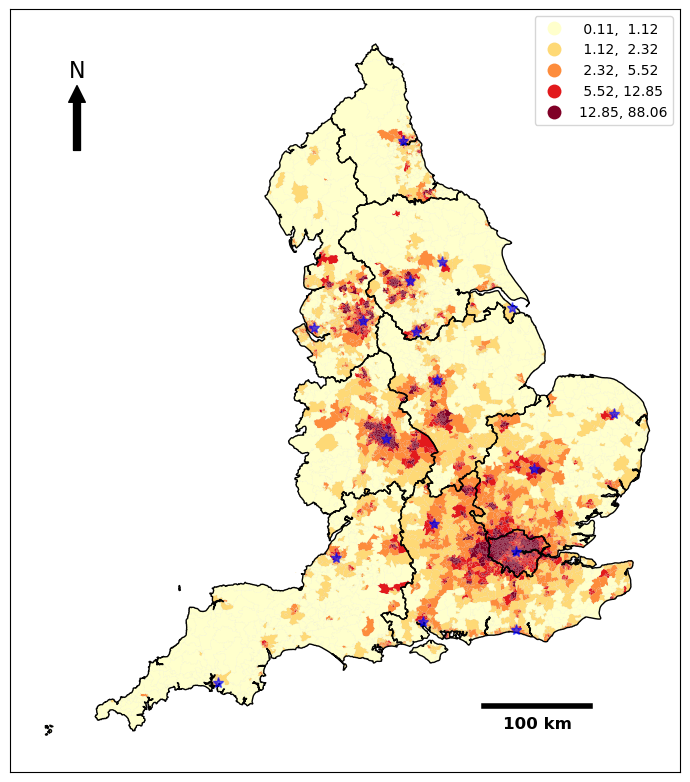

In [29]:
# Asian plot
map_plot(7, 10, msoa_england_shp, eng_region, Varshp, 'Asian', 'YlOrRd', 1)